## Overview

In this tutorial, we will be looking at how to launch and connect to an Arkouda server and what that means, before exploring some of the Arkouda API and trying out some data exploration on the NYC taxi cab green data.

1. Launching and connecting to an Arkouda server
2. Read Parquet taxi cab data
3. Data exploration
    - descriptive statistics
    - histogram
    - logical indexing
4. Create a lookup table and DataFrame
     - GroupBy
     - Broadcast
5. Working with NumPy/Pandas

## Download data
https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet - green taxi cab Parquet

https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv - lookup table CSV

## Installing Arkouda

Installation intructions can be found at: 

And Docker images can be found at: https://github.com/Bears-R-Us/arkouda-contrib/tree/main/arkouda-docker

## Connect to the Arkouda server

When using Arkouda, a Python client connects to an Arkouda server that is running in a separate process. This Arkouda server is a parallel, distributed Chapel application that stores arrays, executes commands, and communicate a human-understandable response back to the client.

In order to connect to an Arkouda server, you must ensure one has been started by:
1. Launch an Arkouda server: `./arkouda_server -nl <number-of-locales>`
2. Import Arkouda in your Python client: `import arkouda as ak`
3. Connect to the server, passing the hostname and portnumber of the server: `ak.connect(<hostname>, <port>)`
    - This server can be running on your local machine, a supercomputer, the cloud, or anywhere! 

In [1]:
import arkouda as ak
ak.connect('localhost', 5555) 

    _         _                   _       
   / \   _ __| | _____  _   _  __| | __ _ 
  / _ \ | '__| |/ / _ \| | | |/ _` |/ _` |
 / ___ \| |  |   < (_) | |_| | (_| | (_| |
/_/   \_\_|  |_|\_\___/ \__,_|\__,_|\__,_|
                                          

Client Version: v2023.02.08+495.g8cc410ca3


connected to arkouda server tcp://*:5555


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import gc

## Read Parquet Taxi Cab Data

Today, Arkouda supports a couple of staple file formats:
- Parquet: data science columnar file format
- HDF5: HPC file format designed for large data sets
- CSV: Standard file format for small data sets

The NYC Taxi cab data is given in Parquet format, a file format readable by Arkouda.

When possible, it is recommended to use Parquet or HDF5 for IO in Arkouda, since the performance with those formats are much better than CSV.

When writing files in Arkouda, one file per locale is written to disk. For example, if you are writing a large dataset that is distributed across a 16-locale server, 16 files will be written, 1 per locale, each named with the pattern `<filename-prefix>_LOCALE####`.

There are currently efforts to add support for additional file formats, such as Zarr and NetCDF, as well as efforts to improve the performance of existing formats.

In [3]:
columns = ['VendorID',
           'lpep_pickup_datetime',
           'lpep_dropoff_datetime',
           'fare_amount',
           'PULocationID',
           'DOLocationID']
data = ak.read('./green_tripdata_2024-01.parquet', columns)

In [4]:
data

{'VendorID': array([2 2 2 ... 2 2 2]),
 'lpep_pickup_datetime': array([1704070015000000 1704069102000000 1704069021000000 ... 1706736960000000 1706741100000000 1706740080000000]),
 'lpep_dropoff_datetime': array([1704070705000000 1704070354000000 1704070163000000 ... 1706737200000000 1706741460000000 1706741940000000]),
 'fare_amount': array([12.800000000000001 30.300000000000001 19.800000000000001 ... 11.58 14.220000000000001 44.619999999999997]),
 'PULocationID': array([236 65 74 ... 72 41 33]),
 'DOLocationID': array([239 170 262 ... 72 42 91])}

In [5]:
data = ak.DataFrame(data)
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,fare_amount,PULocationID,DOLocationID
0,2,1704070015000000,1704070705000000,12.80,236,239
1,2,1704069102000000,1704070354000000,30.30,65,170
2,2,1704069021000000,1704070163000000,19.80,74,262
3,1,1704069020000000,1704069732000000,14.20,74,116
4,2,1704069158000000,1704069817000000,22.60,74,243
...,...,...,...,...,...,...
56546,2,1706733960000000,1706734500000000,11.58,33,25
56547,2,1706735160000000,1706735460000000,11.58,72,72
56548,2,1706736960000000,1706737200000000,11.58,72,72
56549,2,1706741100000000,1706741460000000,14.22,41,42


In [6]:
rows = data['VendorID'].size
numbytes = sum(v.size*v.itemsize for v in data.values())

In [7]:
print(f'{rows:,} rows\n{numbytes:,} bytes')

56,551 rows
2,714,448 bytes


## Data Exploration

Arrays in Arkouda are called `pdarray`s. When you create a `pdarray`, your Python client essentially stores a reference to the data that is actually stored in the parallel, distributed object store of the Arkouda server. What this means is that calls and queries operating on the pdarray will be sent to the Arkouda server, where they are executed in parallel and then returned in a human-readable way, without ever having to store the data in the memory of the machine where the Python client is running.

Arkouda's interface is based off of the NumPy/Pandas APIs so as to provide an interface that doesn't require a steep learning curve for data scientists who are used to traditional single-locale tools.

Today, Arkouda supports a subset of the NumPy/Pandas operations as well as some specific functions that come in handy when working with distributed data.

Some key supported features:
- `groupby`
- `argsort`
- `DataFrame`
- `Random`
- set operations
- ...

More information on the Arkouda API can be found at: https://bears-r-us.github.io/arkouda/

### Descriptive statistics

Supports standard NumPy functionality...

These statistics functions are methods on the Arkouda `pdarray` type, so that means they will send a command to the Arkouda server to handle the operaton in a parallel, distributed fashion.

In [8]:
def describe(x):
    fmt = 'mean: {}\nstd: {}\nmin: {}\nmax: {}'
    if x.dtype == ak.float64:
        fmt = fmt.format(*['{:.2f}' for _ in range(4)])
    print(fmt.format(x.mean(), x.std(), x.min(), x.max()))

In [9]:
describe(data['fare_amount'])

mean: 16.93
std: 15.36
min: -70.00
max: 1422.60


#### Histogram

Arkouda supports transferring of distribtued arrays back to the client through ZMQ (messaging layer, similar to TCP sockets) and converting them to NumPy ndarrays. 

This can be useful for taking a portion of an Arkouda array to operate on at a smaller scale and interoparate with existing Python tools, like PySpark. In this example, a single column of our Arkouda array is converted to a NumPy array in order to work with MatPlotLib.

In [10]:
import numpy as np
from matplotlib import pyplot as plt

def hist(x, bins, log=True):
    assert bins > 0
    h, bins = ak.histogram(x, bins)
    plt.bar(bins[:-1].to_ndarray(), h.to_ndarray(), width=bins[1]-bins[0])
    if log:
        plt.yscale('log')

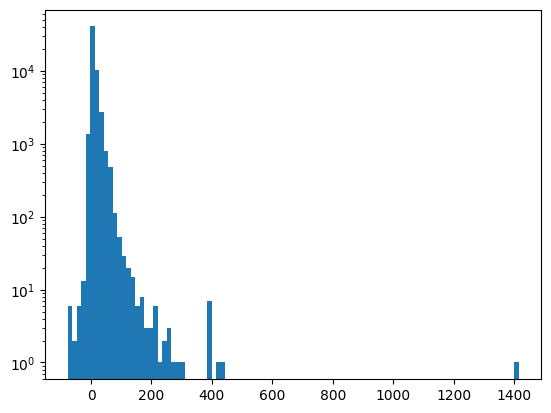

In [11]:
hist(data['fare_amount'], 100)

#### Logical Indexing (Filters)

When creating our filter variable, `nonneg`, this will actually be a `pdarray`, meaning that the data is still being stored in the distributed object store of the Arkouda server and not the Python client. Remember, the Python client only has references to `pdarray`s, not the actual data.

With the Arkouda paradigm, writing code with pdarrays looks like any other Python code, but is leveraging the parallel, distributed server. This enables scientists who are not familiar with parallel and distributed concepts to write code that scales and performs well.

In [12]:
data[data['fare_amount'] > 1000]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,fare_amount,PULocationID,DOLocationID
23148,2,1705258918000000,1705316694000000,1422.6,92,265


In [13]:
non_neg = data['fare_amount'] >= 0
print(f'{non_neg.sum() / non_neg.size : .1%} of fares are non-negative')

 99.7% of fares are non-negative


In [14]:
describe(data['fare_amount'][non_neg])

mean: 17.01
std: 15.29
min: 0.00
max: 1422.60


In [15]:
data = ak.DataFrame({k:v[non_neg] for k, v in data.items()})

In [16]:
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,fare_amount,PULocationID,DOLocationID
0,2,1704070015000000,1704070705000000,12.80,236,239
1,2,1704069102000000,1704070354000000,30.30,65,170
2,2,1704069021000000,1704070163000000,19.80,74,262
3,1,1704069020000000,1704069732000000,14.20,74,116
4,2,1704069158000000,1704069817000000,22.60,74,243
...,...,...,...,...,...,...
56364,2,1706733960000000,1706734500000000,11.58,33,25
56365,2,1706735160000000,1706735460000000,11.58,72,72
56366,2,1706736960000000,1706737200000000,11.58,72,72
56367,2,1706741100000000,1706741460000000,14.22,41,42


In [17]:
data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']

0         690000000
1        1252000000
2        1142000000
3         712000000
4         659000000
            ...    
56364     540000000
56365     300000000
56366     240000000
56367     360000000
56368    1860000000
dtype: int64
Length 56369

In [18]:
describe(data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime'])

mean: 1093375667.4768047
std: 4534775245.459212
min: 0
max: 86339000000


# Taxi Zone Lookup Table

### Use method 1: CSV -> Pandas -> Arkouda
Arkouda supports working with Pandas DataFrames, which can be used to augment large Arkouda pdarrays or DataFrames, or converted to Arkouda pdarrays to get better performance.

In [19]:
import pandas as pd

def cvt_to_string(v):
    try:
        if v == '':
            return 'N/A'
        else:
            return str(v)
    except:
        return 'N/A'

cvt = {'Borough':cvt_to_string, 'Zone':cvt_to_string, 'service zone':cvt_to_string}
tzlut = pd.read_csv('./taxi_zone_lookup.csv', converters=cvt)

top_row = pd.DataFrame({'LocationID': [0], 'Borough': ['N/A'], 'service_zone':['N/A']})
tzlut = pd.concat([top_row, tzlut]).reset_index(drop=True)

In [20]:
tzlut

,LocationID,Borough,service_zone,Zone
0,0,N/A,N/A,NaN
1,1,EWR,EWR,Newark Airport
2,2,Queens,Boro Zone,Jamaica Bay
3,3,Bronx,Boro Zone,Allerton/Pelham Gardens
4,4,Manhattan,Yellow Zone,Alphabet City
...,...,...,...,...
261,261,Manhattan,Yellow Zone,World Trade Center
262,262,Manhattan,Yellow Zone,Yorkville East
263,263,Manhattan,Yellow Zone,Yorkville West
264,264,Unknown,NaN,N/A


#### Convert Pandas DF to Arkouda DF

In [21]:
def ak_create_from_df(df):
    akdict = {}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=str)
        else:
            akdict[cname] = ak.from_series(df[cname])
    return ak.DataFrame(akdict)

In [22]:
aktzlut = ak_create_from_df(tzlut)

In [23]:
aktzlut

,LocationID,Borough,service_zone,Zone
0,0,N/A,N/A,nan
1,1,EWR,EWR,Newark Airport
2,2,Queens,Boro Zone,Jamaica Bay
3,3,Bronx,Boro Zone,Allerton/Pelham Gardens
4,4,Manhattan,Yellow Zone,Alphabet City
...,...,...,...,...
261,261,Manhattan,Yellow Zone,World Trade Center
262,262,Manhattan,Yellow Zone,Yorkville East
263,263,Manhattan,Yellow Zone,Yorkville West
264,264,Unknown,nan,N/A


#### Apply Lookup Table

After ensuring that our array is zero-up indexed, we can enhance our Arkouda dictionary by broadcasting values.

In [24]:
(aktzlut['LocationID'] == ak.arange(aktzlut['LocationID'].size)).all()

True

In [25]:
data['PUBorough'] = aktzlut['Borough'][data['PULocationID']]
data['DOBorough'] = aktzlut['Borough'][data['DOLocationID']]

In [26]:
data['PUZone'] = aktzlut['Zone'][data['PULocationID']]
data['DOZone'] = aktzlut['Zone'][data['DOLocationID']]

In [27]:
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,fare_amount,PULocationID,DOLocationID,PUBorough,DOBorough,PUZone,DOZone
0,2,1704070015000000,1704070705000000,12.80,236,239,Manhattan,Manhattan,Upper East Side North,Upper West Side South
1,2,1704069102000000,1704070354000000,30.30,65,170,Brooklyn,Manhattan,Downtown Brooklyn/MetroTech,Murray Hill
2,2,1704069021000000,1704070163000000,19.80,74,262,Manhattan,Manhattan,East Harlem North,Yorkville East
3,1,1704069020000000,1704069732000000,14.20,74,116,Manhattan,Manhattan,East Harlem North,Hamilton Heights
4,2,1704069158000000,1704069817000000,22.60,74,243,Manhattan,Manhattan,East Harlem North,Washington Heights North
...,...,...,...,...,...,...,...,...,...,...
56364,2,1706733960000000,1706734500000000,11.58,33,25,Brooklyn,Brooklyn,Brooklyn Heights,Boerum Hill
56365,2,1706735160000000,1706735460000000,11.58,72,72,Brooklyn,Brooklyn,East Flatbush/Remsen Village,East Flatbush/Remsen Village
56366,2,1706736960000000,1706737200000000,11.58,72,72,Brooklyn,Brooklyn,East Flatbush/Remsen Village,East Flatbush/Remsen Village
56367,2,1706741100000000,1706741460000000,14.22,41,42,Manhattan,Manhattan,Central Harlem,Central Harlem North


In [28]:
data[data['fare_amount'] > 1000]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,fare_amount,PULocationID,DOLocationID,PUBorough,DOBorough,PUZone,DOZone
23071,2,1705258918000000,1705316694000000,1422.6,92,265,Queens,N/A,Flushing,Outside of NYC


#### GroupBy: Construct a Graph
Define graph from PULocationID -> DOLocationID

The bread and butter of what makes Arkouda valuable is it's sort (and hence GroupBy). If large sorts are a bottleneck, Arkouda is likely a great option! 

The GroupBy functionality in Arkouda has spawned off another project from NJIT (Arachne) that can be thought of as the "NetworkX of supercompters". Arachne provides interactive large-scale graph algorithms with the Python frontend provided by Arkouda.

In [29]:
byloc = ak.GroupBy([data['PULocationID'], data['DOLocationID']])

In [30]:
byloc.unique_keys

(array([1 3 3 ... 265 265 265]), array([1 132 166 ... 244 264 265]))

Edge weight is the number of rides from our grouping (pickup location to drooff location)

In [31]:
(u, v), w = byloc.size()

In [32]:
u, v, w

(array([1 3 3 ... 265 265 265]),
 array([1 132 166 ... 244 264 265]),
 array([3 1 1 ... 1 2 8]))

#### Broadcast: Find Rides with Anomalous Fares
Compute mean and stddev of fare by (pickup, dropoff)

In [33]:
_, mf = byloc.mean(data['fare_amount'])

In [34]:
sf = (byloc.sum(data['fare_amount']**2)[1] / w) - mf**2

Broadcast group values back to ride dataframe to compute z-score of rides

In [35]:
data['fare_mean'] = byloc.broadcast(mf, permute=True)
data['fare_std'] = byloc.broadcast(sf, permute=True)

In [36]:
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,fare_amount,PULocationID,DOLocationID,PUBorough,DOBorough,PUZone,DOZone,fare_mean,fare_std
0,2,1704070015000000,1704070705000000,12.80,236,239,Manhattan,Manhattan,Upper East Side North,Upper West Side South,12.927273,3.012893
1,2,1704069102000000,1704070354000000,30.30,65,170,Brooklyn,Manhattan,Downtown Brooklyn/MetroTech,Murray Hill,32.075000,21.794375
2,2,1704069021000000,1704070163000000,19.80,74,262,Manhattan,Manhattan,East Harlem North,Yorkville East,16.232353,8.394496
3,1,1704069020000000,1704069732000000,14.20,74,116,Manhattan,Manhattan,East Harlem North,Hamilton Heights,14.125985,4.668585
4,2,1704069158000000,1704069817000000,22.60,74,243,Manhattan,Manhattan,East Harlem North,Washington Heights North,22.976526,9.634553
...,...,...,...,...,...,...,...,...,...,...,...,...
56364,2,1706733960000000,1706734500000000,11.58,33,25,Brooklyn,Brooklyn,Brooklyn Heights,Boerum Hill,9.365556,12.111725
56365,2,1706735160000000,1706735460000000,11.58,72,72,Brooklyn,Brooklyn,East Flatbush/Remsen Village,East Flatbush/Remsen Village,18.290000,57.524100
56366,2,1706736960000000,1706737200000000,11.58,72,72,Brooklyn,Brooklyn,East Flatbush/Remsen Village,East Flatbush/Remsen Village,18.290000,57.524100
56367,2,1706741100000000,1706741460000000,14.22,41,42,Manhattan,Manhattan,Central Harlem,Central Harlem North,8.687568,7.676142


In [37]:
data['fare_z'] = (data['fare_amount'] - data['fare_mean']) / (data['fare_std'] + 1)

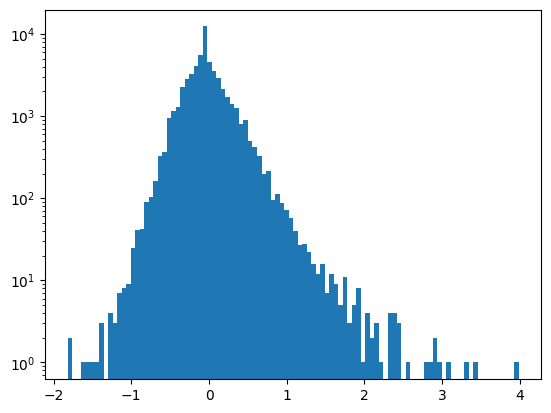

In [38]:
hist(data['fare_z'], 100)

#### Bring Small Result Set Back to Pandas
Now, we've explored our data, we've discovered insights, and now we know what we need to look at: rides that are extraordinarily expensive! 

To work with that how you would any other Python code, the pdarray can be converted from the server side as a pdarray to the client side as a NumPy ndarray or Pandas DataFrame.

In [39]:
exorbitant = (data['fare_z'] > 2)
exdf = pd.DataFrame({k: v[exorbitant].to_ndarray() for k, v in data.items()})

In [40]:
exdf.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,fare_amount,PULocationID,DOLocationID,PUBorough,DOBorough,PUZone,DOZone,fare_mean,fare_std,fare_z
0,2,1704189533000000,1704191837000000,35.2,74,262,Manhattan,Manhattan,East Harlem North,Yorkville East,16.232353,8.394496,2.019017
1,2,1704216769000000,1704220033000000,29.0,74,42,Manhattan,Manhattan,East Harlem North,Central Harlem North,9.894750,7.878999,2.151735
2,2,1704273255000000,1704274871000000,23.3,74,41,Manhattan,Manhattan,East Harlem North,Central Harlem,8.793904,5.947687,2.087903
3,1,1704291873000000,1704292665000000,25.0,43,263,Manhattan,Manhattan,Central Park,Yorkville West,9.942449,5.981229,2.156862
4,2,1704300121000000,1704303378000000,52.0,75,166,Manhattan,Manhattan,East Harlem South,Morningside Heights,13.264087,12.132838,2.949546


In [41]:
worst = data['fare_z'].argmax()
{k:v[worst] for k, v in data.items()}

{'VendorID': 1,
 'lpep_pickup_datetime': 1706711409000000,
 'lpep_dropoff_datetime': 1706714350000000,
 'fare_amount': 41.5,
 'PULocationID': 74,
 'DOLocationID': 75,
 'PUBorough': 'Manhattan',
 'DOBorough': 'Manhattan',
 'PUZone': 'East Harlem North',
 'DOZone': 'East Harlem South',
 'fare_mean': 10.35688900747066,
 'fare_std': 6.763855476474276,
 'fare_z': 4.01129452845921}

### Disconnect From or Shutdown Server

In [42]:
# ak.disconnect()
#ak.shutdown()